In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import os
import cv2
import shutil
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
train_dir = 'C:/Users/Ishant Naru/brain tumor data/train'
val_dir = 'C:/Users/Ishant Naru/brain tumor data/val'
test_dir = 'C:/Users/Ishant Naru/brain tumor data/test'

In [3]:
#reproducibility
np.random.seed(45)
tf.random.set_seed(45)

In [4]:
from keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=0.1,
                width_shift_range=0.3,
                height_shift_range=0.3,
                #shear_range=0.3,
                zoom_range=0.4,
                #horizontal_flip= True
                )
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
#uploading images in batches in train_generator and validation_generator 

train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(200,200),
                batch_size=50,
                class_mode='binary',
                color_mode='rgb')

validation_generator = test_datagen.flow_from_directory(
                val_dir,
                target_size=(200,200),
                batch_size=20,
                class_mode='binary',
                color_mode='rgb')

Found 2759 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [6]:
#Convolutional Base = Inception 

from tensorflow.keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet',
                             include_top=False,
                             input_shape=(200,200,3))

conv_base.trainable=False

#Fully Connected Neural Network Base 

fcnn = keras.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(300, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

fcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 24576)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               7373100   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 61,710,137
Trainable params: 7,373,401
Non-trainable params: 54,336,736
_________________________________________________________________


In [7]:
#compiling step
from tensorflow.keras.optimizers import RMSprop

fcnn.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate= 1e-4),
              metrics = ['accuracy'])

In [8]:
#Creating Callbacks 

checkpoint_cb=keras.callbacks.ModelCheckpoint("BrainTumorInception.h5", save_best_only=True)
early_stop_cb=keras.callbacks.EarlyStopping(min_delta=0.0001, patience=4, restore_best_weights=True)

In [9]:
# #Fitting the model 
history_1 = fcnn.fit(
            train_generator,
            steps_per_epoch=56,
            epochs = 30,
            validation_data=validation_generator,
            validation_steps=46,
            callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/30
56/56 [==============================] - 435s 8s/step - loss: 1.0761 - accuracy: 0.7209 - val_loss: 0.5037 - val_accuracy: 0.7388
Epoch 2/30
56/56 [==============================] - 397s 7s/step - loss: 0.4896 - accuracy: 0.7749 - val_loss: 0.3539 - val_accuracy: 0.8509
Epoch 3/30
56/56 [==============================] - 953s 17s/step - loss: 0.4557 - accuracy: 0.7916 - val_loss: 0.5655 - val_accuracy: 0.7345
Epoch 4/30
56/56 [==============================] - 415s 7s/step - loss: 0.3874 - accuracy: 0.8394 - val_loss: 0.2926 - val_accuracy: 0.8770
Epoch 5/30
56/56 [==============================] - 431s 8s/step - loss: 0.4189 - accuracy: 0.8123 - val_loss: 0.3489 - val_accuracy: 0.8368
Epoch 6/30
56/56 [==============================] - 400s 7s/step - loss: 0.3574 - accuracy: 0.8489 - val_loss: 0.2940 - val_accuracy: 0.8738
Epoch 7/30
56/56 [==============================] - 397s 7s/step - loss: 0.3706 - accuracy: 0.8427 - val_loss: 0.3055 - val_accuracy: 0.8672
Epoch 8/30
5

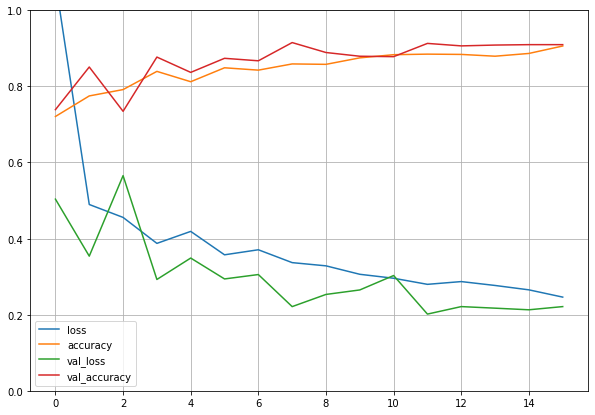

In [11]:
pd.DataFrame(history_1.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [12]:
#Evaluating on test set 

test_generator = test_datagen.flow_from_directory(
                test_dir,
                target_size=(200,200),
                batch_size=40,
                color_mode='rgb',
                class_mode='binary')

Found 922 images belonging to 2 classes.


In [13]:
fcnn.evaluate(test_generator, steps=25)

25/25 [==============================] - 92s 4s/step - loss: 0.1978 - accuracy: 0.9187


[0.19780446588993073, 0.9186550974845886]

In [15]:
pred_dir = 'C:/Users/Ishant Naru/brain tumor data/pred'

pred_generator = test_datagen.flow_from_directory(
                pred_dir,
                target_size=(200,200),
                batch_size=5,
                shuffle=False,
                class_mode=None,
                color_mode='rgb')

Found 40 images belonging to 1 classes.


In [17]:
predictions = fcnn.predict(pred_generator, steps=8)

In [19]:
print(predictions)

[[3.2733381e-02]
 [3.1419867e-01]
 [1.1005640e-02]
 [2.7487248e-01]
 [6.6284760e-05]
 [5.6758648e-01]
 [1.9281477e-02]
 [4.2175324e-07]
 [1.6882628e-01]
 [8.0628051e-05]
 [1.5955478e-02]
 [4.2325258e-04]
 [2.4048963e-01]
 [4.0548593e-02]
 [1.8940568e-03]
 [6.1206222e-02]
 [5.7515502e-03]
 [9.7730505e-01]
 [2.0846945e-01]
 [4.6834230e-01]
 [9.9788761e-01]
 [8.5989523e-01]
 [6.6206300e-01]
 [9.8915684e-01]
 [9.9194562e-01]
 [7.8935426e-01]
 [9.6259558e-01]
 [9.5921516e-01]
 [8.6871660e-01]
 [8.2169056e-02]
 [9.9600935e-01]
 [9.8223925e-01]
 [7.9253328e-01]
 [9.8733330e-01]
 [9.8922020e-01]
 [5.3348297e-01]
 [9.8711455e-01]
 [9.4235891e-01]
 [9.9907947e-01]
 [8.0228996e-01]]


In [20]:
cl = np.round(predictions)
filenames=pred_generator.filenames

In [22]:
results=pd.DataFrame({"file":filenames,"pr":predictions[:,0], "class":cl[:,0]})
print(results)

                          file            pr  class
0          pred\Cancer (1).jpg  3.273338e-02    0.0
1         pred\Cancer (10).jpg  3.141987e-01    0.0
2         pred\Cancer (12).jpg  1.100564e-02    0.0
3         pred\Cancer (19).tif  2.748725e-01    0.0
4         pred\Cancer (28).jpg  6.628476e-05    0.0
5         pred\Cancer (28).tif  5.675865e-01    1.0
6         pred\Cancer (30).jpg  1.928148e-02    0.0
7         pred\Cancer (33).jpg  4.217532e-07    0.0
8         pred\Cancer (33).tif  1.688263e-01    0.0
9         pred\Cancer (34).jpg  8.062805e-05    0.0
10        pred\Cancer (35).jpg  1.595548e-02    0.0
11        pred\Cancer (36).jpg  4.232526e-04    0.0
12        pred\Cancer (37).tif  2.404896e-01    0.0
13        pred\Cancer (38).jpg  4.054859e-02    0.0
14        pred\Cancer (46).tif  1.894057e-03    0.0
15        pred\Cancer (47).tif  6.120622e-02    0.0
16        pred\Cancer (51).tif  5.751550e-03    0.0
17        pred\Cancer (56).tif  9.773051e-01    1.0
18         p